In [1]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import nibabel as nib
from scipy.stats import zscore
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pickle

subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']


# Load subcortical atlas
BN_atlas = nib.load("../utils/brain_atlas/BN_fmriprep.nii").get_fdata()
hippocampus_idx = [215, 216, 217, 218]
hippocampus_label = ['rostral-left','rostral-right','caudal-left','caudal-right']

# Load cortical atlas (Schaefer2018)
Schaefer_atlas_parcel = [100,200,300,400,500,600,700,800,900,1000]
Schaefer_atlas = []
for num_rois in Schaefer_atlas_parcel:
    Schaefer_atlas.append(nib.load(f"../utils/brain_atlas/Schaefer2018_cortical_{num_rois}_3mm.nii.gz").get_fdata())

save = False
if save:
    hippocampal_timeseries = np.zeros((len(subjects), 610))
    cortical_timeseries = np.zeros((len(subjects), len(Schaefer_atlas_parcel)), dtype='object')
    for s, fname in enumerate(subjects):
        print(fname)
        path = f'/DATA2/FilmMemory_preprocess/mrbean_scrambled/{fname}_scrambled_smoothing_scale.nii.gz'
        fmri_data = nib.load(path).get_fdata()

        tmp = []
        for roi in hippocampus_idx:
            roi_timeseries = zscore(fmri_data[BN_atlas==roi, :].T, axis=0)
            roi_timeseries = np.nan_to_num(roi_timeseries).mean(axis=1) #610, #voxels
            tmp.append(roi_timeseries)
        hippocampal_timeseries[s,:] = np.mean(tmp, axis=0).astype(np.double)

        for j, num_rois in enumerate(Schaefer_atlas_parcel):
            tmp_timeseries = np.zeros((610, num_rois))
            for r in range(num_rois):
                roi_timeseries = zscore(fmri_data[Schaefer_atlas[j]==r+1,:].T, axis=0)
                roi_timeseries = np.nan_to_num(roi_timeseries).mean(axis=1) #610, #voxels
                tmp_timeseries[:,r] = np.array(roi_timeseries).astype(np.double)
            cortical_timeseries[s,j] = tmp_timeseries
    np.save(f'data/hippocampal_timeseries.npy', hippocampal_timeseries)
    np.save(f'data/cortical_timeseries.npy', cortical_timeseries)
else:
    hippocampal_timeseries = np.load(f'data/hippocampal_timeseries.npy')
    cortical_timeseries = np.load(f'data/cortical_timeseries.npy', allow_pickle=True)

content_score = np.load("../Figure_3/data/content_score.npy")
ordering_score = np.load("../Figure_3/data/ordering_score.npy")

In [2]:
import pickle
with open('../utils/movie/backward_retrieval_related.pkl', 'rb') as f:
    backward_retrieval_related = pickle.load(f)
with open('../utils/movie/backward_retrieval_unrelated.pkl', 'rb') as f:
    backward_retrieval_unrelated = pickle.load(f)

with open('../utils/movie/forward_retrieval_related.pkl', 'rb') as f:
    forward_retrieval_related = pickle.load(f)
with open('../utils/movie/forward_retrieval_unrelated.pkl', 'rb') as f:
    forward_retrieval_unrelated = pickle.load(f)
    
all_timepoints = np.ones(610)
retrieval_moments = np.zeros(610)
backward_retrieval_moments = np.zeros(610)
forward_retrieval_moments = np.zeros(610)

for pair in forward_retrieval_related:
    forward_retrieval_moments[pair[1]+3:pair[1]+7] = 1
    retrieval_moments[pair[1]+3:pair[1]+7] = 1

for pair in backward_retrieval_related:
    backward_retrieval_moments[pair[1]-8:pair[1]-2] = 1
    retrieval_moments[pair[1]-8:pair[1]-2] = 1

scene_change = np.array([34,  69,  103, 140, 176, 209, 243, 276, 313, 346, 382, 421, 458, 491, 527, 566, 599])
post_boundaries = np.zeros(610)
for s, scene in enumerate(scene_change):
    post_boundaries[scene+5:scene+9] = 1
    
times = [all_timepoints, post_boundaries,
         retrieval_moments,
         backward_retrieval_moments, forward_retrieval_moments]

In [4]:

save = False
if save:
    hippocampal_FC = []
    for nr, num_rois in enumerate(Schaefer_atlas_parcel):
        print(num_rois)
        tmp_hippocampal_FC = np.zeros((len(subjects), num_rois, len(times)))
        for i, fname in enumerate(subjects):
            for t, time in enumerate(times):
                for r in range(num_rois):
                    tmp_hippocampal_FC[i,r,t] = pearsonr(hippocampal_timeseries[i,time==1], cortical_timeseries[i,nr][time==1, r])[0]
        hippocampal_FC.append(tmp_hippocampal_FC)
    print('done!')

    with open('data/hippocampal_FC.pkl', 'wb') as f:
        pickle.dump(hippocampal_FC, f)
else:
    with open('data/hippocampal_FC.pkl', 'rb') as f:
        hippocampal_FC = pickle.load(f)

In [5]:
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_prediction(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    print(f"#predictive edges:{len(positive_edges)+len(negative_edges)}")
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

save = True
if save:
    model_predictivity = np.zeros((len(Schaefer_atlas_parcel), 2, len(times)))
    for nr, num_rois in enumerate(Schaefer_atlas_parcel):
        num_edges = num_rois
        for b, behavioral_score in enumerate([ordering_score, content_score]):
            if b == 0:
                name='ordering'
            else:
                name='content'
            predictivity_r = []
            for t, time in enumerate(times):
                #dFC  = hippocampal_FC[nr][:,:,t]
                FC  = hippocampal_FC[nr][:,:,t]
                FC = np.arctanh(FC)
                with Pool() as pool:
                    behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(len(subjects))])
                r, p = pearsonr(behavioral_prediction, behavioral_score)
                predictivity_r.append(r)
                model_predictivity[nr, b, t] = r
            print(num_rois, name, predictivity_r)
    #np.save('data/model_predictivity.npy', model_predictivity)
else:
    model_predictivity = np.load('data/model_predictivity.npy')

#predictive edges:9
#predictive edges:8#predictive edges:8#predictive edges:10#predictive edges:8#predictive edges:9#predictive edges:9
#predictive edges:9#predictive edges:8#predictive edges:9



#predictive edges:8#predictive edges:7#predictive edges:9#predictive edges:8
#predictive edges:8
#predictive edges:9#predictive edges:9#predictive edges:9#predictive edges:13#predictive edges:5#predictive edges:9#predictive edges:9
#predictive edges:9
#predictive edges:10#predictive edges:9#predictive edges:7#predictive edges:10
#predictive edges:6#predictive edges:8#predictive edges:11#predictive edges:6


#predictive edges:7#predictive edges:10#predictive edges:7


#predictive edges:10


#predictive edges:12#predictive edges:7
#predictive edges:11#predictive edges:6#predictive edges:7

#predictive edges:12#predictive edges:7#predictive edges:8

#predictive edges:11#predictive edges:6#predictive edges:9
#predictive edges:10
#predictive edges:6





#predictive edges:12
#predictive edges:8




KeyboardInterrupt: 

[(0.4, 0.6, 0.8666666666666667), (0.37157723441966395, 0.5503790190787208, 0.7893072952068069), (0.3431544688393279, 0.5007580381574416, 0.7119479237469472), (0.31371660448826555, 0.4493648793461167, 0.6318257175920924), (0.2852938389079295, 0.3997438984248375, 0.5544663461322326), (0.25585597455686704, 0.3483507396135126, 0.4743441399773778), (0.22743320897653102, 0.2987297586922334, 0.396984768517518), (0.19799534462546864, 0.2473365998809085, 0.3168625623626632), (0.1695725790451326, 0.1977156189596293, 0.23950319090280348), (0.1411498134647965, 0.14809463803835013, 0.1621438194429436)]


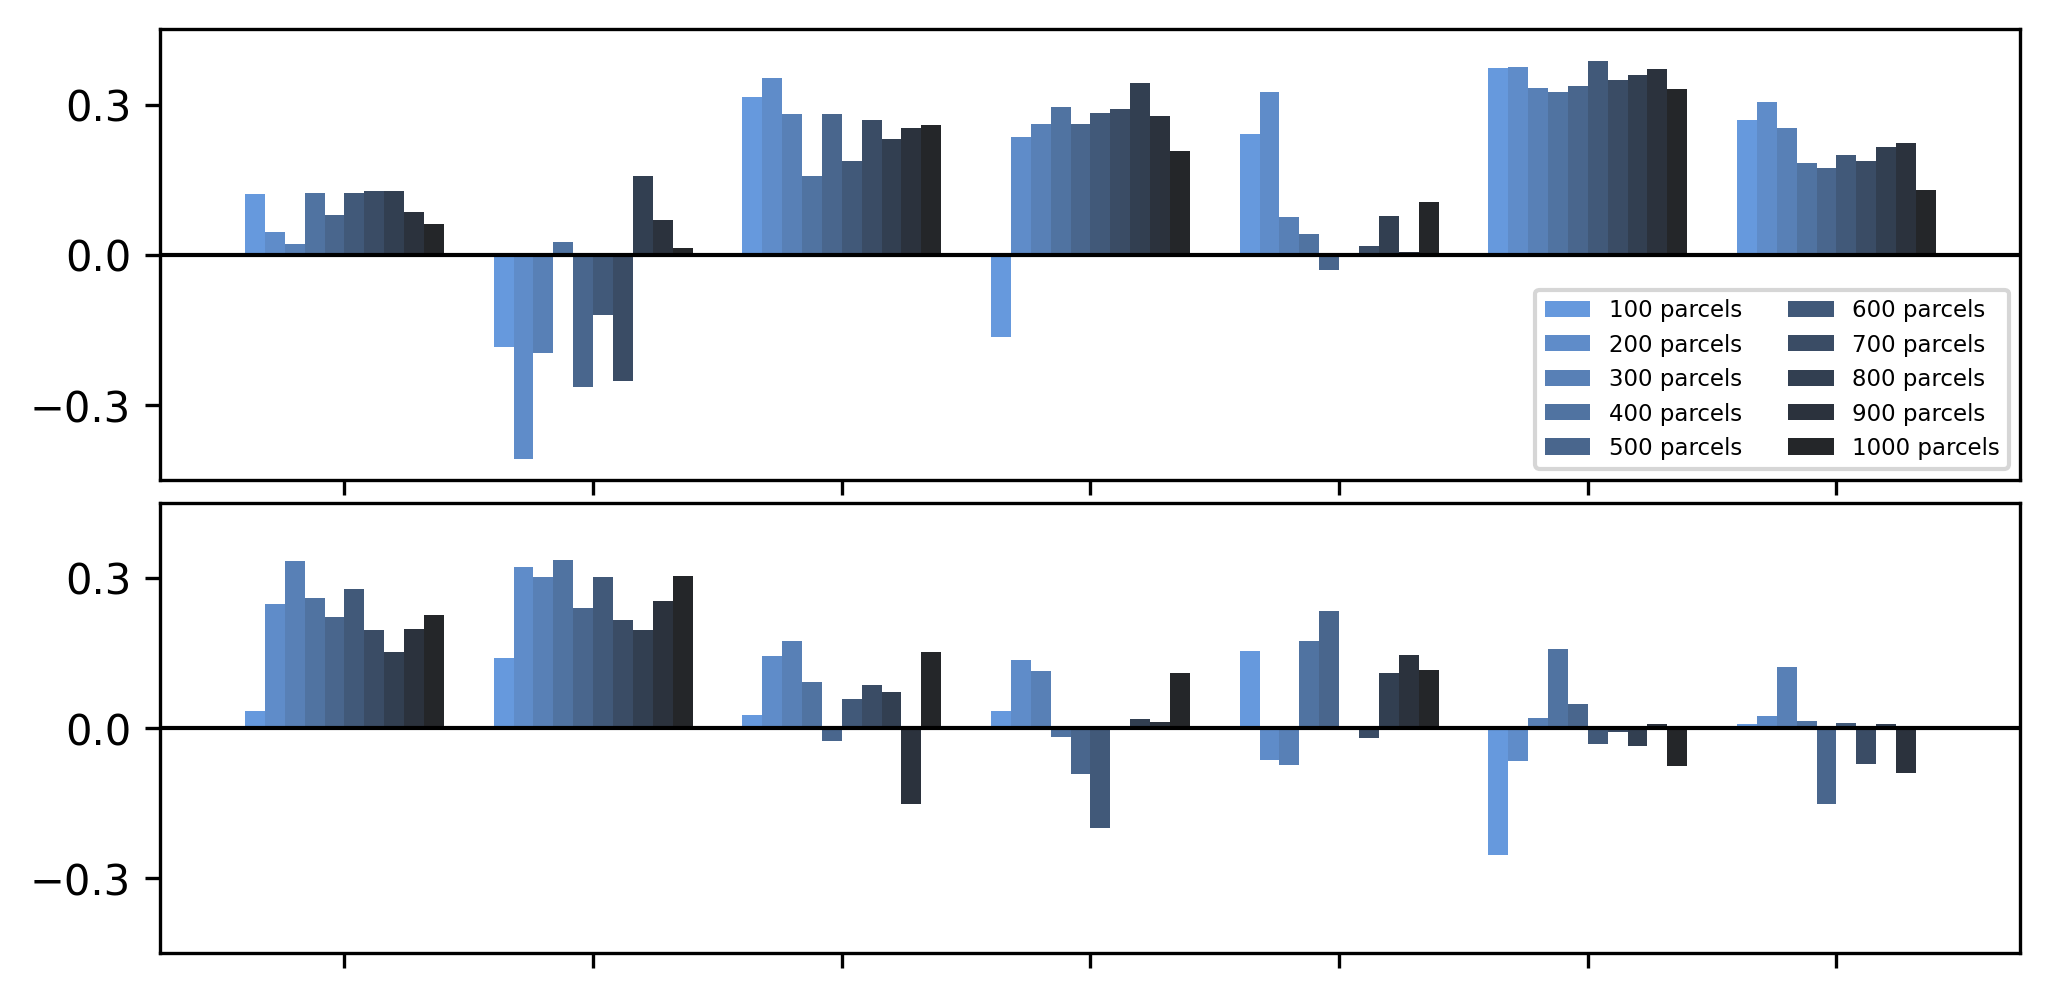

In [20]:
import seaborn as sns
model_predictivity = np.load('data/model_predictivity.npy')
model_predictivity_BERT = np.load('../Figure_6/data/BERT_based_model_predictivity.npy')
model_predictivity_similarity = np.load('../Figure_6/data/similarity_based_model_predictivity.npy')
plt.style.use('default')
color_palette = sns.dark_palette("#69d", 10, reverse=True)
print(color_palette)
score_type = 0
fig, axes = plt.subplots(2, 1, figsize=(8,4), dpi=300, sharex=True, sharey=True)
width = 0.08
x = np.arange(len(times))
for b, behavioral_score in enumerate([ordering_score, content_score]):
    for nr, num_rois in enumerate(Schaefer_atlas_parcel):
        axes[b].bar(x + width*nr, model_predictivity[nr,b,[0,1,2,3,4]], width=width,
                    color=color_palette[nr], label=f'{num_rois} parcels', zorder=5)
        axes[b].bar(np.array([5]) + width*nr, model_predictivity_BERT[nr,b,1], width=width,
            color=color_palette[nr], zorder=5)
        axes[b].bar(np.array([6]) + width*nr, model_predictivity_BERT[nr,b,4], width=width,
            color=color_palette[nr], zorder=5)
    axes[b].set_yticks([-0.3, 0.0, 0.3])
axes[b].set_xticks(np.arange(7)+width*4+width/2)
axes[b].set_xticklabels([])
axes[0].legend(loc='lower right', ncol=2, prop={'size': 5.5})

for ax in axes:
    #ax.grid(axis='y', zorder=0)
    ax.axhline(0.0, c='k', lw=1, zorder=5)
plt.ylim(-0.45, 0.45)
plt.subplots_adjust(hspace=0.05)
plt.show()

In [16]:
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_nulldistribution(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score_suffle[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score_suffle[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

atlas_idx = 1
num_rois = Schaefer_atlas_parcel[atlas_idx]
print("#ROIs:", num_rois)
num_edges = num_rois

times = [all_timepoints, post_boundaries,
         retrieval_moments,
         end_retrieval_moments, onset_retrieval_moments]

with open('data/hippocampal_FC.pkl', 'rb') as f:
    hippocampal_FC = pickle.load(f)

N_permutations = 1000
model_random_permutation = np.zeros((2,len(times),N_permutations))
for b, behavioral_score in enumerate([ordering_score, content_score]):
    if b == 0:
        name='ordering'
    else:
        name='content'
    for t, time in enumerate(times):
        FC = hippocampal_FC[atlas_idx][:,:,t]
        FC = np.arctanh(FC)
        np.random.seed(0)  # For reproducibility
        for p in range(N_permutations):
            if p % 100 == 0:
                print("Score type:", name, "Time idx:", t, f'{100*p/N_permutations:3.3f}%')
            behavioral_score_suffle = np.copy(behavioral_score[np.random.permutation(len(subjects))])
            with Pool() as pool:
                behavioral_prediction = pool.map(get_LOO_nulldistribution, [i for i in np.arange(len(subjects))])
            r, _ = pearsonr(behavioral_score_suffle, behavioral_prediction)
            model_random_permutation[b,t,p] = r

np.save('data/null_predictivity.npy', model_random_permutation)

#ROIs: 200
Score type: ordering Time idx: 0 0.000%
Score type: ordering Time idx: 0 10.000%
Score type: ordering Time idx: 0 20.000%
Score type: ordering Time idx: 0 30.000%
Score type: ordering Time idx: 0 40.000%
Score type: ordering Time idx: 0 50.000%
Score type: ordering Time idx: 0 60.000%
Score type: ordering Time idx: 0 70.000%
Score type: ordering Time idx: 0 80.000%
Score type: ordering Time idx: 0 90.000%
Score type: ordering Time idx: 1 0.000%
Score type: ordering Time idx: 1 10.000%
Score type: ordering Time idx: 1 20.000%
Score type: ordering Time idx: 1 30.000%
Score type: ordering Time idx: 1 40.000%
Score type: ordering Time idx: 1 50.000%
Score type: ordering Time idx: 1 60.000%
Score type: ordering Time idx: 1 70.000%
Score type: ordering Time idx: 1 80.000%
Score type: ordering Time idx: 1 90.000%
Score type: ordering Time idx: 2 0.000%
Score type: ordering Time idx: 2 10.000%
Score type: ordering Time idx: 2 20.000%
Score type: ordering Time idx: 2 30.000%
Score ty

## Whole-brain cortical FC without Hippocampus

In [3]:
times = [all_timepoints, post_boundaries, retrieval_moments]
import pickle
num_rois = 200
save = True
if save:
    wholebrain_FC = np.zeros((len(subjects), int(num_rois*(num_rois-1)/2), len(times)))
    for i, fname in enumerate(subjects):
        for t, time in enumerate(times):
            counter = 0
            for r_1 in range(num_rois):
                for r_2 in range(num_rois):
                    if r_1 > r_2:
                        wholebrain_FC[i,counter,t] = pearsonr(cortical_timeseries[i,1][time==1, r_1],
                                                              cortical_timeseries[i,1][time==1, r_2])[0]
                        counter+=1
    print('done!')

    np.save('data/wholebrain_FC_without_HPC.npy', wholebrain_FC)
else:
    wholebrain_FC = np.load('data/wholebrain_FC_without_HPC.npy')

done!


In [4]:
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_prediction(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

num_rois = 200
num_edges = int(num_rois*(num_rois-1)/2)
save = True
if save:
    model_predictivity = np.zeros((2, len(times)))
    for b, behavioral_score in enumerate([ordering_score, content_score]):
        if b == 0:
            name='ordering'
        else:
            name='content'
        predictivity_r = []
        for t, time in enumerate(times):
            FC = wholebrain_FC[:,:,t]
            FC = np.arctanh(FC)
            with Pool() as pool:
                behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(len(subjects))])
            r, p = pearsonr(behavioral_prediction, behavioral_score)
            predictivity_r.append(r)
            model_predictivity[b, t] = r
        print(num_rois, name, predictivity_r)
    np.save('data/model_predictivity_wholebrain_without_HPC.npy', model_predictivity)
else:
    model_predictivity = np.load('data/model_predictivity_wholebrain_without_HPC.npy')

200 ordering [-0.032663088984404, -0.12321198419622084, -0.033177652439618066]
200 content [0.1812195269507542, 0.0718328950461142, 0.03407902168194228]


In [5]:
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_nulldistribution(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score_suffle[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score_suffle[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred


num_rois = 200
num_edges = int(num_rois*(num_rois-1)/2)
N_permutations = 1000
save = True
if save:
    model_random_permutation = np.zeros((2,len(times),N_permutations))
    for b, behavioral_score in enumerate([ordering_score, content_score]):
        if b == 0:
            name='ordering'
        else:
            name='content'
        for t, time in enumerate(times):
            FC  = wholebrain_FC[:,:,t]
            FC = np.arctanh(FC)
            np.random.seed(0)
            for p in range(N_permutations):
                if p % 100 == 0:
                    print("Score type:", name, "Time idx:", t, f'{100*p/N_permutations:3.3f}%')
                behavioral_score_suffle = np.copy(behavioral_score[np.random.permutation(len(subjects))])
                with Pool() as pool:
                    behavioral_prediction = pool.map(get_LOO_nulldistribution, [i for i in np.arange(len(subjects))])
                r, _ = pearsonr(behavioral_score_suffle, behavioral_prediction)
                model_random_permutation[b,t,p] = r

    np.save("data/null_predictivity_wholebrain_without_HPC.npy", model_random_permutation)

Score type: ordering Time idx: 0 0.000%
Score type: ordering Time idx: 0 10.000%
Score type: ordering Time idx: 0 20.000%
Score type: ordering Time idx: 0 30.000%
Score type: ordering Time idx: 0 40.000%
Score type: ordering Time idx: 0 50.000%
Score type: ordering Time idx: 0 60.000%
Score type: ordering Time idx: 0 70.000%
Score type: ordering Time idx: 0 80.000%
Score type: ordering Time idx: 0 90.000%
Score type: ordering Time idx: 1 0.000%
Score type: ordering Time idx: 1 10.000%
Score type: ordering Time idx: 1 20.000%
Score type: ordering Time idx: 1 30.000%
Score type: ordering Time idx: 1 40.000%
Score type: ordering Time idx: 1 50.000%
Score type: ordering Time idx: 1 60.000%
Score type: ordering Time idx: 1 70.000%
Score type: ordering Time idx: 1 80.000%
Score type: ordering Time idx: 1 90.000%
Score type: ordering Time idx: 2 0.000%
Score type: ordering Time idx: 2 10.000%
Score type: ordering Time idx: 2 20.000%
Score type: ordering Time idx: 2 30.000%
Score type: orderin

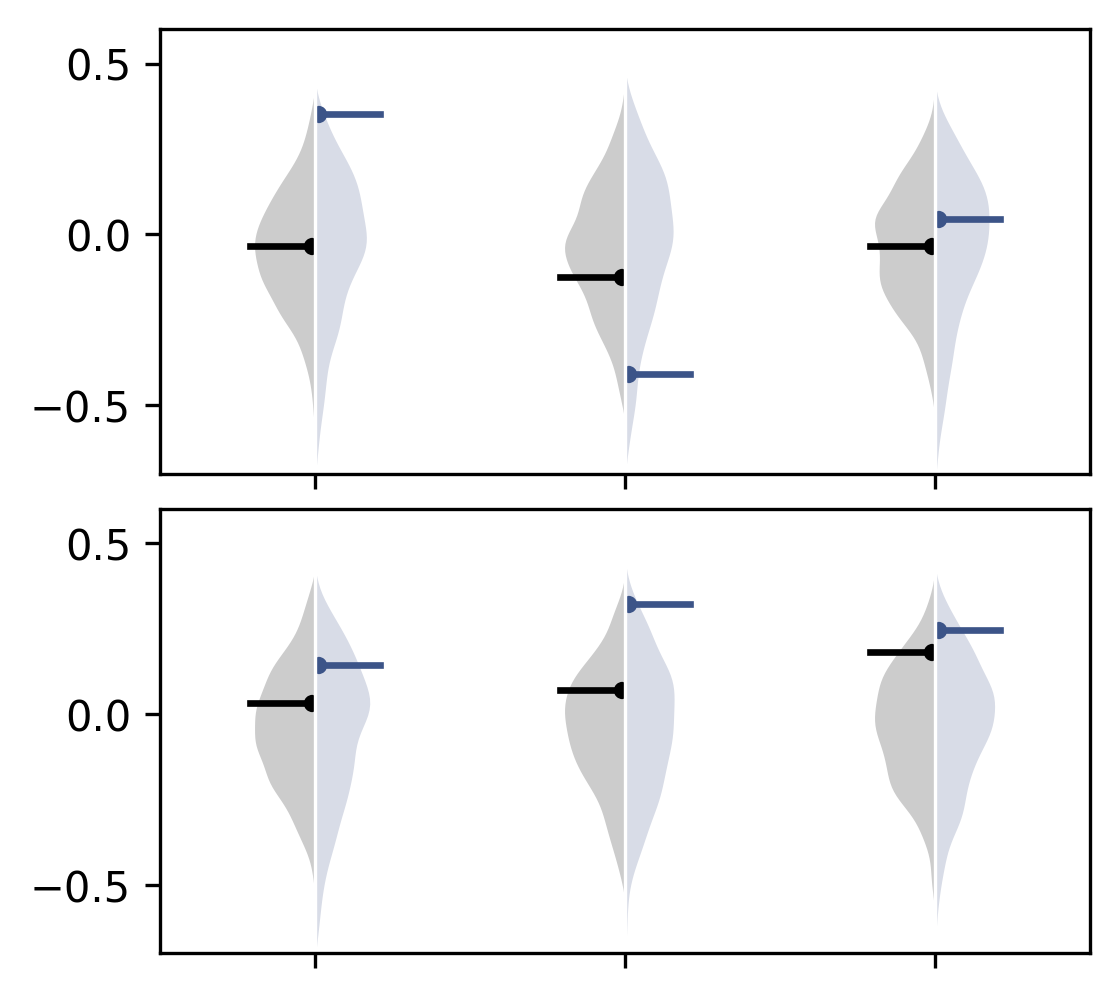

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import PolyCollection
from matplotlib.markers import MarkerStyle

def patch_violinplot():
     for ax in axes:
         for art in ax.get_children():
              if isinstance(art, PolyCollection):
                  art.set_edgecolor((1.0, 1.0, 1.0))

hippocampal_predictivity = np.load('data/model_predictivity.npy')[1]
wholebrain_predictivity_wo_HPC = np.load('data/model_predictivity_wholebrain_without_HPC.npy')
#wholebrain_predictivity_w_HPC = np.load('model_predictivity_wholebrain_with_HPC.npy')

null_hippocampal_predictivity = np.load('data/null_predictivity.npy')
null_wholebrain_predictivity_wo_HPC = np.load('data/null_predictivity_wholebrain_without_HPC.npy')
#null_wholebrain_predictivity_w_HPC = np.load('wholebrain_model_with_HPC_random_permutation_N1000.npy')

dfs = []
for b in range(2):
    df = pd.DataFrame(data={'null':np.hstack([null_wholebrain_predictivity_wo_HPC[b,2,:],
                                              null_hippocampal_predictivity[b,2,:],
                                              null_wholebrain_predictivity_wo_HPC[b,1,:],
                                              null_hippocampal_predictivity[b,1,:],
                                              null_wholebrain_predictivity_wo_HPC[b,0,:],
                                              null_hippocampal_predictivity[b,0,:]]),
                            'moments':np.hstack([["Retrieval"]*2000 + ['Post']*2000 + ['All']*2000]),
                            'type':np.hstack([["wholebrain"]*1000 + ['hipp']*1000]*3)})
    dfs.append(df)

displayed_timepoints = np.array([2,1,0])

import seaborn as sns
plt.style.use('default')
color_palette = sns.color_palette("crest", 10)

fig, axes = plt.subplots(2, 1, figsize=(4,4), dpi=300, sharex=True, sharey=True)
width = 0.22
offset = 0.008
offset2 = 0.01
x = np.arange(len(displayed_timepoints))

#color_list= [[0.2,0.2,0.2], [60/255,84/255,136/255]]*3
color_list= [[0.0,0.0,0.0,0.2],[60/255,84/255,136/255, 0.2]]*3

for b in range(2):

    sns.violinplot(data=dfs[b], x='moments', y='null',
                   split=True, hue='type',
                   ax=axes[b], width=0.4, inner=None, color="#777777",
                   points=100, showmeans=False, showextrema=False, showmedians=False, linewidth=0.6, zorder=1)
    for i, v in enumerate(axes[b].findobj(PolyCollection)):
        v.set_facecolor(color_list[i])
    axes[b].scatter([0+offset,1+offset,2+offset],
                    [hippocampal_predictivity[b,2],
                            hippocampal_predictivity[b,1],
                              hippocampal_predictivity[b,0]], s=10, c='#3C5488',marker=MarkerStyle("o", fillstyle="right"))
    axes[b].plot([0+offset,0.2+offset], [hippocampal_predictivity[b,2],hippocampal_predictivity[b,2]], c='#3C5488', lw=1.6)
    axes[b].plot([1+offset,1.2+offset], [hippocampal_predictivity[b,1],hippocampal_predictivity[b,1]], c='#3C5488', lw=1.6)
    axes[b].plot([2+offset,2.2+offset], [hippocampal_predictivity[b,0],hippocampal_predictivity[b,0]], c='#3C5488', lw=1.6)
    axes[b].scatter([0-offset2,1-offset2,2-offset2],
                    [wholebrain_predictivity_wo_HPC[b,2],
                     wholebrain_predictivity_wo_HPC[b,1],
                     wholebrain_predictivity_wo_HPC[b,0]], s=10, c='#000000',marker=MarkerStyle("o", fillstyle="left"))
    axes[b].plot([-0.2-offset2,0.0-offset2],
                 [wholebrain_predictivity_wo_HPC[b,2],wholebrain_predictivity_wo_HPC[b,2]], c='#000000', lw=1.6)
    axes[b].plot([0.8-offset2,1.0-offset2],
                 [wholebrain_predictivity_wo_HPC[b,1],wholebrain_predictivity_wo_HPC[b,1]], c='#000000', lw=1.6)
    axes[b].plot([1.8-offset2,2.0-offset2],
                 [wholebrain_predictivity_wo_HPC[b,0],wholebrain_predictivity_wo_HPC[b,0]], c='#000000', lw=1.6)

patch_violinplot()
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    ax.set_ylim(-0.7, 0.6)
    ax.legend().set_visible(False)
    ax.set_yticks([-0.5, 0.0, 0.5])
    ax.axvline(0.0, c='w', lw=0.8)
    ax.axvline(1.0, c='w', lw=0.8)
    ax.axvline(2.0, c='w', lw=0.8)
plt.xlim(-0.5,2.5)
plt.subplots_adjust(hspace=0.08)
plt.show()

In [14]:
N_permutations = 1000
for b in range(2):
    for t in [2,1,0]:
        print(b, t, (1+np.sum(null_hippocampal_predictivity[b,t,:]>=hippocampal_predictivity[b,t]))/(1+N_permutations))

0 2 0.01098901098901099
0 1 0.9180819180819181
0 0 0.3876123876123876
1 2 0.1928071928071928
1 1 0.01998001998001998
1 0 0.06693306693306693


PearsonRResult(statistic=-0.36001775939388825, pvalue=0.0032222474207222536)


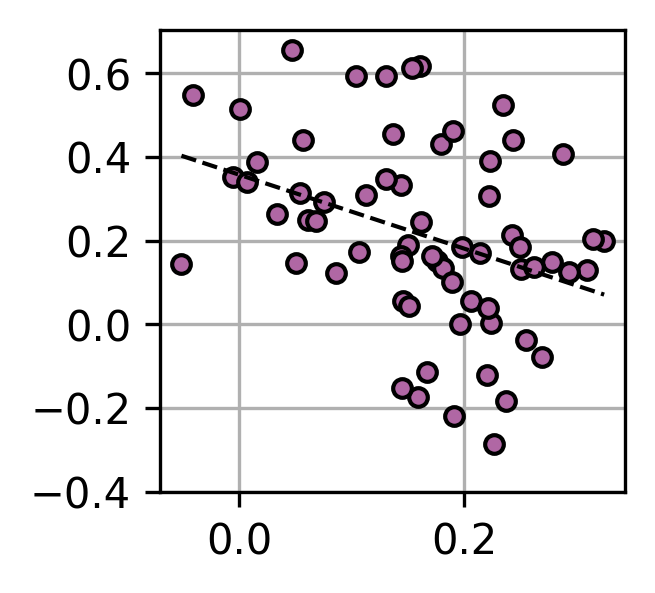

In [16]:
with open('data/hippocampal_FC.pkl', 'rb') as f:
    hippocampal_FC = pickle.load(f)

atlas_idx = 1
num_rois = 200
num_edges = num_rois

roi = 191 -1
plt.style.use('default')
# ordering color '#B067A4'
# content color '#56AE93'
plt.figure(figsize=(2,2), dpi=300)
#plt.scatter(score_m1_content, score_m2_content, s=20)
y = hippocampal_FC[atlas_idx][:,roi, 3]
y = np.arctanh(y)
x = ordering_score
plt.scatter(x, y, s=20, c='#B067A4', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)
plt.grid(True, zorder=0)
plt.yticks([-0.4, -0.2, 0.0, 0.2, 0.4, 0.6])
#plt.ylim(-0.45, 0.65)
#plt.legend(loc='lower right')
#plt.xlabel('Content score (model)')
#plt.ylabel('Content score (hand)')
print(pearsonr(x, y))

PearsonRResult(statistic=0.2929293827862441, pvalue=0.017882174016014912)


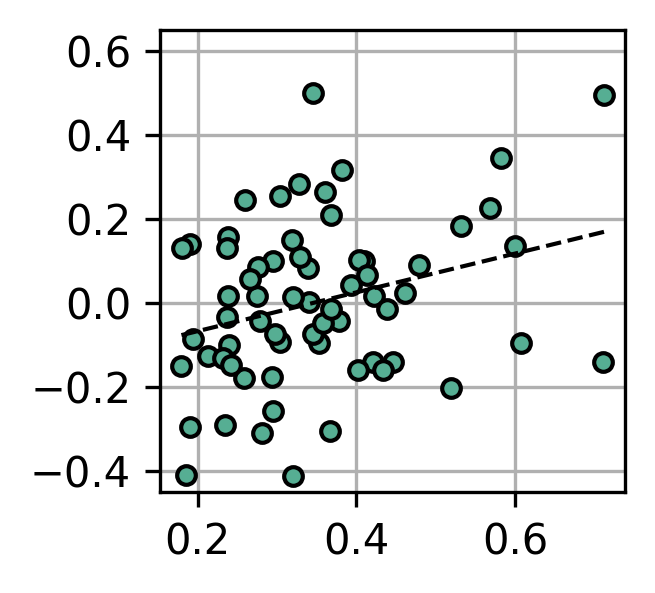

In [17]:
roi = 199 -1
# ordering color '#B067A4'
# content color '#56AE93'
plt.figure(figsize=(2,2), dpi=300)
#plt.scatter(score_m1_content, score_m2_content, s=20)
y = hippocampal_FC[1][:,roi, 1]
y = np.arctanh(y)
x = content_score
plt.scatter(x, y, s=20, c='#56AE93', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
plt.plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p),
         zorder=100, lw=1)
#plt.legend(loc='lower right')
#plt.xlabel('Content score (model)')
#plt.ylabel('Content score (hand)')
plt.yticks([-0.4, -0.2, 0.0, 0.2, 0.4, 0.6])
plt.ylim(-0.45, 0.65)
plt.grid(True, zorder=0)
print(pearsonr(x, y))

In [8]:
from multiprocessing import Pool

with open('data/hippocampal_FC.pkl', 'rb') as f:
    hippocampal_FC = pickle.load(f)
        
selection_threshold = 0.05
def get_num_predictive_edges(test_idx):
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    return len(positive_edges)+len(negative_edges)

times = [all_timepoints, post_boundaries, retrieval_moments]

nr = 1
num_rois = Schaefer_atlas_parcel[nr]
num_edges = num_rois
hippo_edges_pool = []
for b, behavioral_score in enumerate([ordering_score, content_score]):
    if b == 0:
        name='ordering'
    else:
        name='content'
    predictivity_r = []
    for t, time in enumerate(times):
        FC  = hippocampal_FC[nr][:,:,t]
        FC = np.arctanh(FC)
        with Pool() as pool:
            num_predictive_edges = pool.map(get_num_predictive_edges, [i for i in np.arange(len(subjects))])
        print(num_rois, name, t, (np.mean(num_predictive_edges)))
        hippo_edges_pool.append(num_predictive_edges)
#np.save('data/model_predictivity.npy', model_predictivity)


200 ordering 0 15.0
200 ordering 1 6.046153846153846
200 ordering 2 28.876923076923077
200 content 0 11.846153846153847
200 content 1 12.476923076923077
200 content 2 15.63076923076923


In [9]:
wholebrain_FC = np.load('data/wholebrain_FC_without_HPC.npy')
num_rois = Schaefer_atlas_parcel[nr]
num_edges = num_rois
full_edges_pool = []
for b, behavioral_score in enumerate([ordering_score, content_score]):
    if b == 0:
        name='ordering'
    else:
        name='content'
    predictivity_r = []
    for t, time in enumerate(times):
        FC = wholebrain_FC[:,:,t]
        FC = np.arctanh(FC)
        with Pool() as pool:
            num_predictive_edges = pool.map(get_num_predictive_edges, [i for i in np.arange(len(subjects))])
        print(num_rois, name, t, (np.mean(num_predictive_edges)))
        full_edges_pool.append(num_predictive_edges)

200 ordering 0 3.0307692307692307
200 ordering 1 2.4307692307692306
200 ordering 2 6.953846153846154
200 content 0 4.430769230769231
200 content 1 9.323076923076924
200 content 2 3.9076923076923076


In [11]:
from scipy.stats import ttest_rel
for i in range(6):
    print(ttest_rel(hippo_edges_pool[i], full_edges_pool[i]))

TtestResult(statistic=34.11960746983911, pvalue=8.91568827739163e-43, df=64)
TtestResult(statistic=18.470471059458696, pvalue=2.4379761324863742e-27, df=64)
TtestResult(statistic=66.75919504799911, pvalue=6.777280029472095e-61, df=64)
TtestResult(statistic=51.047107856074284, pvalue=1.421226460715402e-53, df=64)
TtestResult(statistic=21.387261769249342, pvalue=7.456956872472967e-31, df=64)
TtestResult(statistic=43.580673113173, pvalue=2.6698765180131864e-49, df=64)
